In [1]:
import importlib
import utils.data_loader
import utils.tokenize
import models.embedding
import models.nn

#For reloading
importlib.reload(utils.data_loader)
importlib.reload(utils.tokenize)
importlib.reload(models.embedding)
importlib.reload(models.nn)

Randiko Baan!!


<module 'models.nn' from 'C:\\Users\\bthapama\\Downloads\\projects\\deep-learning\\transformers\\trnsfmr_from_scratch\\models\\nn.py'>

In [48]:
from utils.data_loader import DataLoader
from utils.tokenize import Tokenizer
from data import en,es
from models.embedding import Embeddings
from data import en,es
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [67]:
def reload_modules():
    %load_ext autoreload
    %autoreload 2

In [42]:
reload_modules()
print("This is the implementation of transformer from scratch in PyTorch.........!!")
tokenizer = Tokenizer()
data_loader = DataLoader(
    tokenize_source=tokenizer.tokenize_source,
    tokenize_target=tokenizer.tokenize_target
)
train_set,valid_set,test_set = data_loader.make_dataset(es,en)
vocab_src,vocab_trg = data_loader.build_vocab(train_set,valid_set,test_set)
for word,index in vocab_trg.get_stoi().items():
    if index < 10:
        print(word,index)
# print(f"Tokenized source example: {tokenizer.tokenize_source('Mi nombre es Bimal !! @ 1 23 * ;.')}")
# print(f"Tokenized target example: {tokenizer.tokenize_target('My name is Bimal !! @ 1 23 * ;.')}")
# print(f"Dataset examples: {data_loader.make_dataset(['Mi nombre es Bimal !! @ 1 23 * ;.'],['My name is Bimal !! @ 1 23 * ;.'])}")
# s_tr,s_v,s_te = data_loader.make_dataset(['Mi nombre ','es Bimal !!','@ 1 23 * ;.'],['My name','is Bimal !!','@ 1 23 * ;.'])
# print("train",s_tr,"val",s_v,"test",s_te)
# s_v,s_t = data_loader.build_vocab(s_tr,s_v,s_te)
# print(s_v.get_stoi())
# print(s_t.get_stoi())
# print("Source vobularies:",vocab_src)
embed = nn.Embedding(len(vocab_src),5)
# print(embed(torch.tensor([s_v.get_stoi()['Bimal'],s_v.get_stoi()['nombre']])))
# print(embed(torch.tensor(vocab_src.get_stoi()['víctimas'])))
for tr in train_set[0:2]:
    source_data = torch.tensor(vocab_src(tr["src"]))
    target_data = torch.tensor(vocab_trg(tr["trg"]))
    print(f"{embed(source_data)}\n")
    print(f"{embed(target_data)}\n")
# print(embed(torch.tensor(vocab_src(train_set[0]["src"]))))
# print(embed(torch.tensor(vocab_trg(train_set[0]["trg"]))))
# print(len(train_set[0]["src"]))
# print(len(train_set[0]["trg"]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
This is the implementation of transformer from scratch in PyTorch.........!!
Initializing the data loader........
Building Spanish Vocabulary.....
Done Building Spanish Vocabulary!
Buidling English Vocabulary.........
Done building English Vocabulary!
. 7
<unk> 0
<eos> 3
<pad> 1
the 5
to 9
<sos> 2
, 4
of 6
a 8
tensor([[ 5.5749e-01, -7.8865e-01, -2.7708e-01, -2.3291e-01, -8.4945e-01],
        [-2.1066e+00,  5.9075e-01,  1.2459e-03, -1.1057e-01,  1.7735e-01],
        [ 3.1986e-01, -1.0073e+00, -1.7728e+00, -2.7856e-01, -6.9147e-01],
        [ 2.0885e+00, -5.9621e-01,  4.5372e-01,  9.8975e-01, -3.3422e-04],
        [ 2.7980e-02,  1.5396e+00,  4.8366e-01, -2.8189e-01,  6.3046e-01],
        [ 1.4221e+00,  4.7144e-01,  7.2093e-01, -1.0106e+00, -2.3563e+00],
        [-1.5583e-01,  2.1003e-01, -7.5314e-01,  1.7781e+00,  2.5860e-01],
        [ 9.0732e-02, -1.9098e-01,  9.7097e-01,  8.1745e-01,  7.3396e-02],


In [5]:
m =  nn.Linear(5,5)
input = torch.randn(2,5)
print(f"Input: {input};\n Weights: {m.weight} \n Bias:{m.bias} \n After transformation: {m(input)}\n")

Input: tensor([[-0.3957, -0.7917, -0.8854, -1.0388,  0.2935],
        [ 0.3695,  1.1772, -0.1016, -0.0530,  2.9675]]);
 Weights: Parameter containing:
tensor([[ 0.3889,  0.2105, -0.3361,  0.2118,  0.3607],
        [ 0.0708, -0.0097, -0.3159,  0.0255,  0.0843],
        [ 0.0622, -0.0502, -0.1573,  0.2903, -0.3261],
        [ 0.1617, -0.2933, -0.4009,  0.0485, -0.2035],
        [ 0.2871,  0.1391,  0.1093,  0.3671,  0.4233]], requires_grad=True) 
 Bias:Parameter containing:
tensor([ 0.3889, -0.3022, -0.0681,  0.0988, -0.2972], requires_grad=True) 
 After transformation: tensor([[ 0.2518, -0.0446, -0.3110,  0.5119, -0.8748],
        [ 1.8737, -0.0066, -1.0713, -0.7525,  1.1983]],
       grad_fn=<AddmmBackward0>)



In [6]:
print(f"xA^T + b") # This transformation applies after the nn.Linear is applied.
x = torch.tensor([[-0.3074,  1.5631,  0.5804, -1.0671, -0.6132],
        [-0.1582, -0.2556, -0.1892,  0.0084,  0.7520]])
w = torch.tensor([[-0.1351,  0.0465,  0.2974,  0.0119, -0.1067],
        [-0.2380,  0.2958,  0.1583,  0.0208, -0.1320],
        [-0.3229, -0.1220, -0.2476,  0.1831,  0.1225],
        [ 0.0242,  0.0074,  0.0925, -0.2421, -0.2087],
        [ 0.2182, -0.0354,  0.2494, -0.3794, -0.4260]])
b = torch.tensor([-0.3079,  0.3990,  0.3536, -0.1749,  0.3743])
a = x @ w.t()
o = a + b
print(o)

xA^T + b
tensor([[ 0.0317,  1.0852, -0.1520,  0.2692,  1.0627],
        [-0.4348,  0.2320,  0.5764, -0.3571, -0.0219]])


In [71]:
from models.scaled_dot_product_attention import ScaledDotProductAttention
print(f"The attention scores of of the first sentence in our dataset\n")
first_sentence_src = train_set[0]["src"]
first_sen_embed_src = embed(torch.tensor(vocab_src(first_sentence_src)))
print(f"Query, Key and Value shape: {first_sen_embed_src.shape}")
scaled_attn = ScaledDotProductAttention(5)

The attention scores of of the first sentence in our dataset

Query, Key and Value shape: torch.Size([40, 5])


In [77]:
def visualise_attention_scores(scores,words,vocab_type):
    scores_np = scores.detach().numpy()
    plt.figure(figsize=(18,8))
    sns.heatmap(scores_np,xticklabels=words,yticklabels=words,annot=True,fmt='.1f',cmap="Blues")
    plt.title(f"Attention scores visualization for Query and Key of first sentence of {vocab_type}")
    plt.xlabel("Keys")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

torch.Size([40, 40])


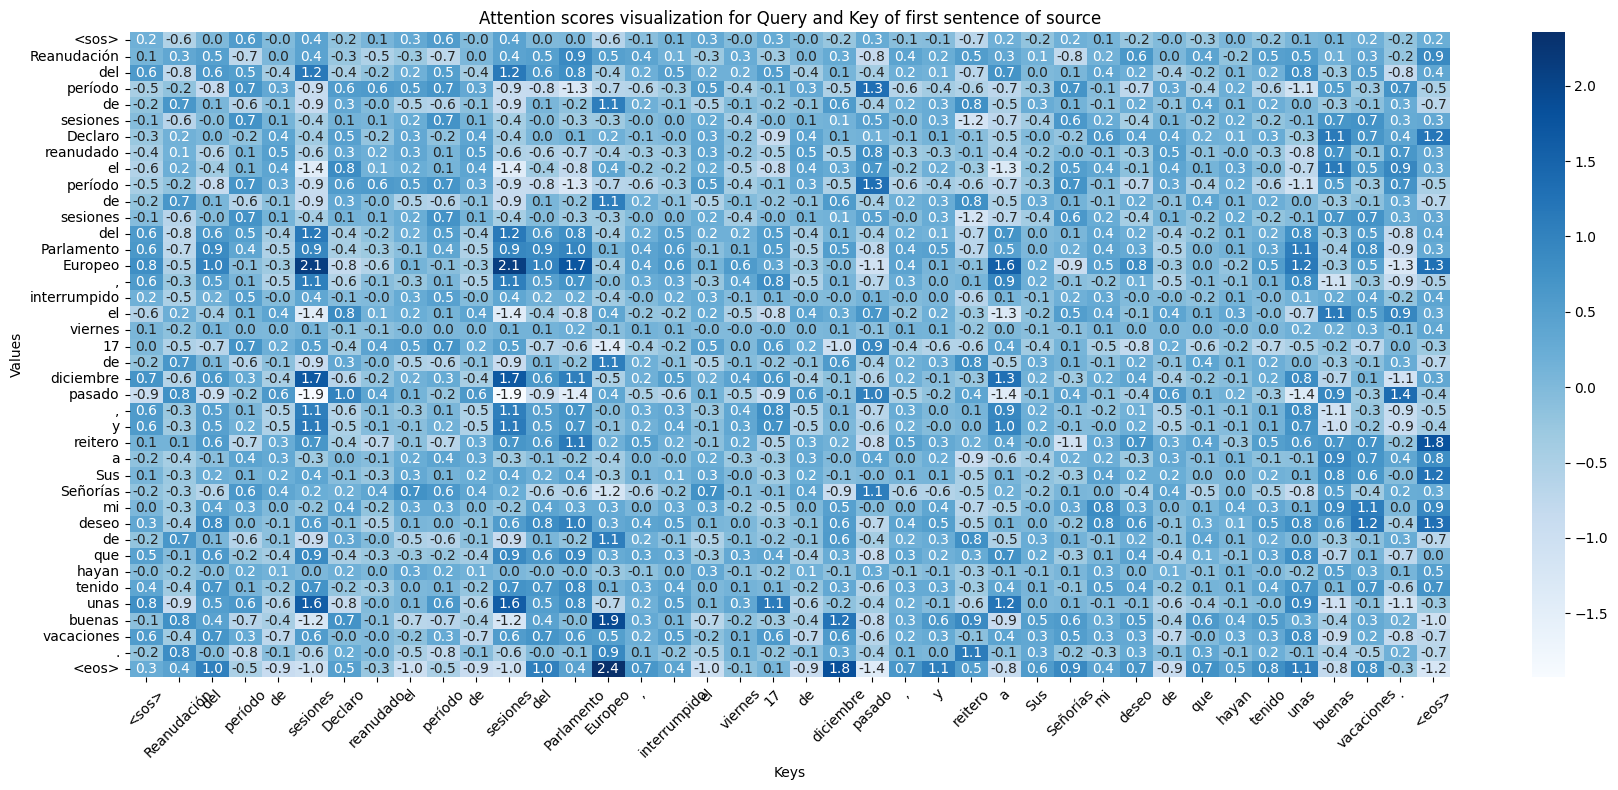

In [80]:
# Convert scores to numpy for visualization
scores = scaled_attn.query_key_attention(first_sen_embed_src,first_sen_embed_src,False)
print(scores.shape)
visualise_attention_scores(scores,first_sentence_src,"source")

tensor([[ 7.4600e-02, -2.5082e-01,  9.1997e-05,  ...,  7.7637e-02,
         -8.3336e-02,  9.8058e-02],
        [ 5.0708e-02,  1.5121e-01,  2.1766e-01,  ...,  1.4698e-01,
         -1.0322e-01,  4.0161e-01],
        [ 2.6496e-01, -3.3685e-01,  2.7324e-01,  ...,  2.1223e-01,
         -3.7272e-01,  1.6634e-01],
        ...,
        [ 2.4879e-01, -1.5698e-01,  3.0879e-01,  ...,  1.1130e-01,
         -3.6493e-01, -3.1659e-01],
        [-8.5314e-02,  3.6581e-01, -1.9256e-02,  ..., -2.1381e-01,
          8.0218e-02, -3.0547e-01],
        [ 1.1227e-01,  1.8839e-01,  4.6253e-01,  ...,  3.5039e-01,
         -1.3665e-01, -5.5134e-01]], grad_fn=<DivBackward0>)


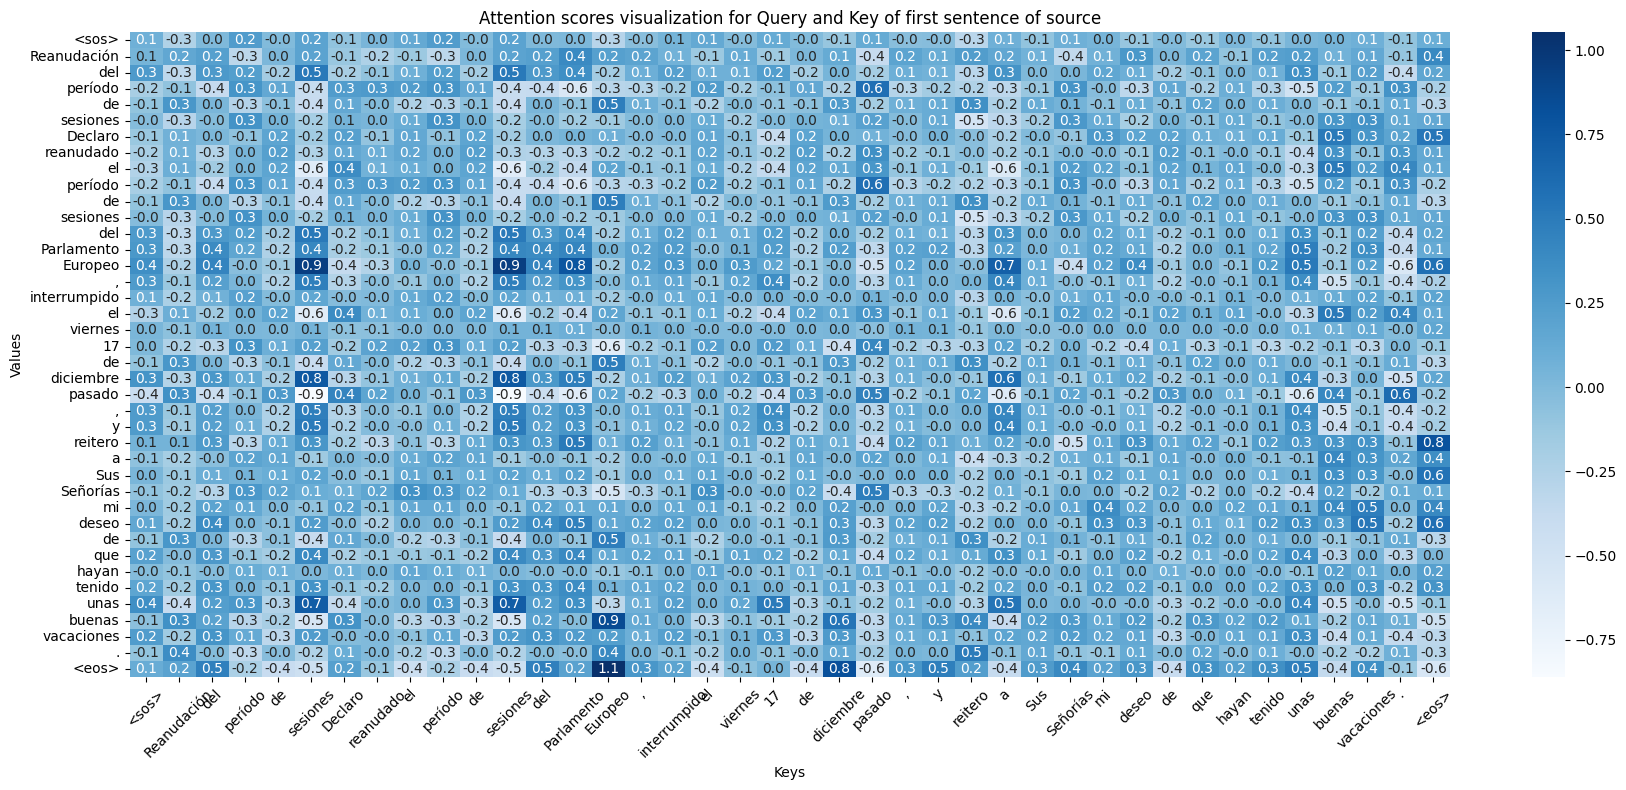

In [86]:
scaled_scores = scaled_attn.query_key_attention(first_sen_embed_src,first_sen_embed_src,True)
# This is scaled attention scores
print(scaled_scores)
visualise_attention_scores(scaled_scores,first_sentence_src,"source")

In [105]:
attention = scaled_attn.forward(first_sen_embed_src,first_sen_embed_src,first_sen_embed_src)
print(attention.shape)

torch.Size([40, 40])
